In [1]:
from fink_utils.sso.spins import estimate_sso_params, func_hg1g2, spin_angle

from fink_utils.sso.periods import estimate_synodic_period  # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import rocks

import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy import linalg

from astropy.coordinates import SkyCoord

import sys

sys.path.append("..")
import ssptools

# import seaborn as sns
# sns.set_context("poster")

In [2]:
def func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period, a_b, a_c, phi0, t0):
    """Return f(H, G1, G2, R, alpha0, delta0) part of the lightcurve in mag space

    Parameters
    ----------
    pha: array-like [4, N]
        List containing [phase angle in radians, RA in radians, Dec in radians, time (jd)]
    h: float
        Absolute magnitude in mag
    G1: float
        G1 parameter (no unit)
    G2: float
        G2 parameter (no unit)
    alpha0: float
        RA of the spin (radian)
    delta0: float
        Dec of the spin (radian)
    period: float
        Spin period (days)
    a_b: float
        Equatorial axes ratio
    a_c: float
        Polar axes ratio
    phi0: float
        Initial rotation phase at reference time t0 (radian)
    t0: float
        Reference time (jd)

    Returns
    -------
    out: array of floats
        H - 2.5 log(f(G1G2)) - 2.5 log(f(spin, shape))
    """
    ph = pha[0]
    ra = pha[1]
    dec = pha[2]
    ep = pha[3]

    # Standard HG1G2 part: h + f(alpha, G1, G2)
    func1 = func_hg1g2(ph, h, g1, g2)

    # Spin part
    cos_aspect = spin_angle(ra, dec, alpha0, delta0)
    cos_aspect_2 = cos_aspect**2
    sin_aspect_2 = 1 - cos_aspect_2
    rot_phase = (2 * np.pi * (ep - t0) / period + phi0) % (2 * np.pi)
    
    # new
    # https://ui.adsabs.harvard.edu/abs/1985A%26A...149..186P/abstract
    func2 = np.sqrt(
        sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
        + cos_aspect_2 * a_c**2
    )
    func2 = -2.5 * np.log10(func2)

    return func1 + func2

In [3]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "spins.1.period.value",
    "spins.2.period.value",
]

bft = rocks.load_bft(columns=cols)

In [4]:
def func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period, a_b, a_c, phi0, t0):
    """Return f(H, G1, G2, R, alpha0, delta0) part of the lightcurve in mag space

    Parameters
    ----------
    pha: array-like [4, N]
        List containing [phase angle in radians, RA in radians, Dec in radians, time (jd)]
    h: float
        Absolute magnitude in mag
    G1: float
        G1 parameter (no unit)
    G2: float
        G2 parameter (no unit)
    alpha0: float
        RA of the spin (radian)
    delta0: float
        Dec of the spin (radian)
    period: float
        Spin period (days)
    a_b: float
        Equatorial axes ratio
    a_c: float
        Polar axes ratio
    phi0: float
        Initial rotation phase at reference time t0 (radian)
    t0: float
        Reference time (jd)

    Returns
    -------
    out: array of floats
        H - 2.5 log(f(G1G2)) - 2.5 log(f(spin, shape))
    """
    ph = pha[0]
    ra = pha[1]
    dec = pha[2]
    ep = pha[3]

    # Standard HG1G2 part: h + f(alpha, G1, G2)
    func1 = func_hg1g2(ph, h, g1, g2)

    # Spin part
    cos_aspect = spin_angle(ra, dec, alpha0, delta0)
    cos_aspect_2 = cos_aspect**2
    sin_aspect_2 = 1 - cos_aspect_2
    rot_phase = (2 * np.pi * (ep - t0) / period + phi0) % (2 * np.pi)

    # new
    # https://ui.adsabs.harvard.edu/abs/1985A%26A...149..186P/abstract
    func2 = np.sqrt(
        sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
        + cos_aspect_2 * a_c**2
    )
    func2 = -2.5 * np.log10(func2)

    return func1 + func2

## Period estimation

In [5]:
flavor = "SHG1G2"
ssnamenr = 5209
ssnamenr = 136108 # KBO = fixed = Haumea
# ssnamenr = 186153 # High frequency observation
# ssnamenr = 223 # Example article 
ssnamenr = 9799 # JTO lotta obs

period_range = (1 / 24, 7)  # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr,
    flavor=flavor,
    Nterms_base=1,
    period_range=period_range,
    return_extra_info=True,
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0],
    )
)

from erfa import ErfaWarning

 [astropy.utils.exceptions]


[15.75 seconds] model=SHG1G2: period=21.73 hours (chi2red=0.84) -- BFT: period=21.52 hours


# Phase parameters

In [6]:
# Select only a filter
cond = pdf["i:fid"] == 2
pdf = pdf[cond].reset_index(drop=True)

In [7]:
# H G1 G2 estimate
fit_shg1g2 = estimate_sso_params(
    pdf["i:magpsf_red"],
    pdf["i:sigmapsf"],
    np.radians(pdf["Phase"]),
    pdf["i:fid"],
    ra=np.radians(pdf["i:ra"]),
    dec=np.radians(pdf["i:dec"]),
    model="SHG1G2",
)

## Residuals

Text(0, 0.5, 'Residual (mag)')

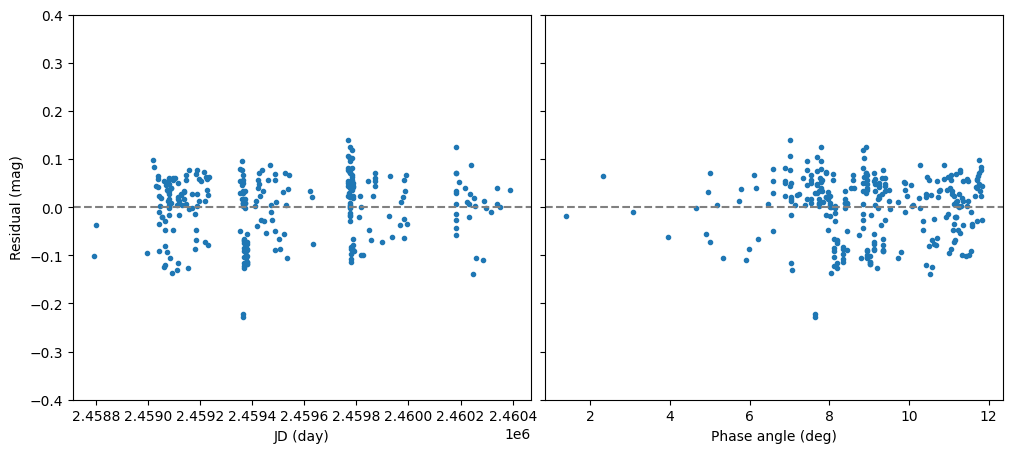

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].plot(pdf["i:jd"][cond], pdf["residuals"][cond], ls="", marker=".")
    ax[1].plot(pdf["Phase"][cond], pdf["residuals"][cond], ls="", marker=".")

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

max_res = 0.4
ax[0].set_ylim(-max_res, max_res)
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("Phase angle (deg)")
ax[0].set_ylabel("Residual (mag)")

## ssHG1G2

parameters
H    9.67
G1   0.50
G2   0.26
RA0  211
DEC0 +38
P    43.5
a/b  1.20
a/c  1.20
phi0 0.00
t0   2459350.00


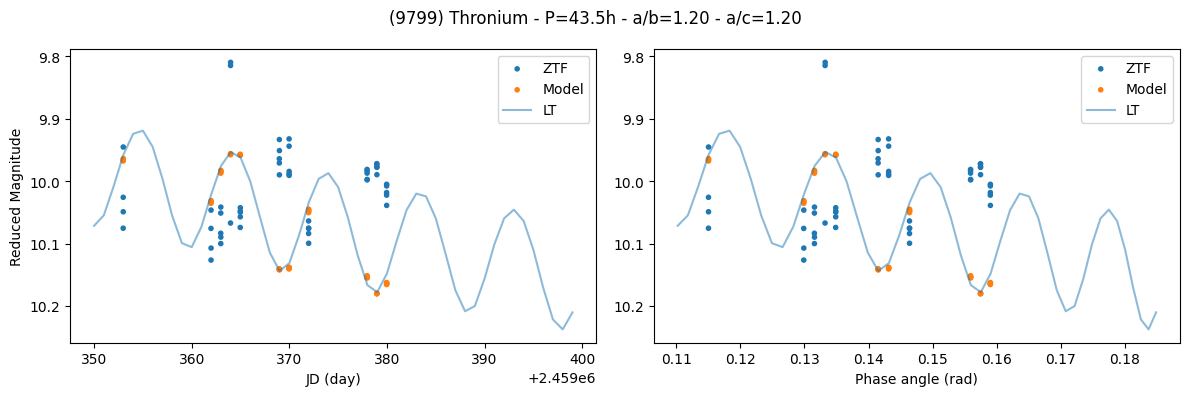

In [9]:
jd0 = 2459802.0  # 5209


match ssnamenr:
    case 223:  # Example from article
        jd0 = 2459800
        t0 = jd0
        len_day = 30
        a_b = 1.2
        a_c = 1.4
        delta_H = 0.1
        phi0 = 0.75
        eph_large, eph_small = True, True
        # eph_large, eph_small = False, False
        jd1 = jd0 + 10
        step = "2h"
        nbd = 200

    case 186153:  # Example with high frequency observations
        jd0 = 2_460_495.550
        t0 = 2_460_495.50
        len_day = 1
        a_b = 3.5
        a_c = 2
        delta_H = 0.5
        phi0 = 0.05
        eph_large, eph_small = False, True
        jd1 = jd0
        step = "10m"
        nbd = 74

    case 136108: # KBO slow mo
        jd0 = 2_460_050.5  
        t0 = jd0
        len_day = 5
        a_b = 1.5
        a_c = 1.5
        delta_H = 0.0
        phi0 = 0.0
        eph_large, eph_small = True, True
        jd1 = jd0
        step = "10min"
        nbd = 700

    case 9799: # JTO Thronium
        jd0 = 2_459_350
        t0 = jd0
        len_day = 50
        a_b = 1.2
        a_c = 1.2
        delta_H = 0.05
        phi0 = 0.0 # Bad
        # phi0 = np.pi/2. # Good 
        eph_large, eph_small = True, False
        jd1 = jd0
        step = "10min"
        nbd = 700

        
    case _:
        jd0 = 2_460_200.0
        t0 = jd0
        len_day = 100
        a_b = 1
        a_c = 1
        delta_H = 0.0
        phi0 = 0.0
        eph_large, eph_small = False, False
        jd1 = jd0
        step = "1h"
        nbd = 24

# --------------------------------------------------------------------------------
# Build parameters
h = fit_shg1g2["H_2"] + delta_H
g1 = fit_shg1g2["G1_2"]
g2 = fit_shg1g2["G2_2"]
alpha0 = np.radians(fit_shg1g2["alpha0"])
delta0 = np.radians(fit_shg1g2["delta0"])
period0 = period * 2 / 24  # Rotation in days (2* LS value: double-peaked lightcurve)

print("parameters")
print(f"H   {h:5.2f}")
print(f"G1   {g1:4.2f}")
print(f"G2   {g2:4.2f}")
print(f"RA0  {np.degrees(alpha0):3.0f}")
print(f"DEC0 {np.degrees(delta0):+3.0f}")
print(f"P    {period0*24:4.1f}")
print(f"a/b  {a_b:4.2f}")
print(f"a/c  {a_c:4.2f}")
print(f"phi0 {phi0:4.2f}")
print(f"t0   {t0:.2f}")

# --------------------------------------------------------------------------------
# Build independent variables
cond = (pdf["i:jd"] > jd0) & (pdf["i:jd"] < jd0 + len_day)

coord = SkyCoord(ra=pdf.loc[cond, "i:ra"], dec=pdf.loc[cond, "i:dec"], unit=("deg", "deg"))
data_ra = coord.ra.rad
data_dec = coord.dec.rad
data_jd = pdf.loc[cond, "i:jd"]
data_phase = np.radians(pdf.loc[cond, "Phase"])
data_mag = pdf.loc[cond, "i:magpsf_red"]

pha = [data_phase.values, data_ra, data_dec, data_jd.values]

# --------------------------------------------------------------------------------
# ssHG1G2
model = func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period0, a_b, a_c, phi0, t0)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(data_jd, data_mag, ls="", marker=".", label="ZTF"
)
ax[0].scatter(data_jd, model, ls="", marker=".", label='Model')

ax[1].scatter(data_phase, data_mag, ls="", marker=".", label="ZTF")
ax[1].scatter(data_phase, model, ls="", marker=".", label="Model")
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("Phase angle (rad)")
ax[0].set_ylabel("Reduced Magnitude")


# --------------------------------------------------------------------------------
# Long term behavior
if eph_large:
    eph = ssptools.ephemcc(ssnamenr, ep=jd0, step="1d", nbd=len_day)
    f = 5*np.log10( eph.Dobs * eph.Dhelio)

    coord = SkyCoord(ra=eph["RA"], dec=eph["DEC"], unit=("hour", "deg"))
    eph_ra = coord.ra.rad
    eph_dec = coord.dec.rad
    eph_phase = np.radians(eph["Phase"])
    eph_jd = eph["Date"]
    pha_eph = [eph_phase.values, eph_ra, eph_dec, eph_jd.values]

    model_eph = func_sshg1g2(
        pha_eph, h, g1, g2, alpha0, delta0, period0, a_b, a_c, phi0, t0
    ) 
    ax[0].plot(eph_jd, model_eph, ls="solid", alpha=0.5, color='C0', label="LT")
    ax[1].plot(eph_phase, model_eph, ls="solid", alpha=0.5, color='C0', label="LT")


# --------------------------------------------------------------------------------
# Short term behavior
if eph_small:
    eph2 = ssptools.ephemcc(ssnamenr, ep=jd1, step=step, nbd=nbd)
    f = 5*np.log10( eph2.Dobs * eph2.Dhelio)

    coord = SkyCoord(ra=eph2["RA"], dec=eph2["DEC"], unit=("hour", "deg"))
    eph2_ra = coord.ra.rad
    eph2_dec = coord.dec.rad
    eph2_phase = np.radians(eph2["Phase"])
    eph2_jd = eph2["Date"]
    pha_eph2 = [eph2_phase.values, eph2_ra, eph2_dec, eph2_jd.values]

    model_eph2 = func_sshg1g2(
        pha_eph2, h, g1, g2, alpha0, delta0, period0, a_b, a_c, phi0, t0
    )
    ax[0].plot(eph2_jd, model_eph2, ls="--", alpha=0.5, color='C1', label="ST")
    ax[1].plot(eph2_phase, model_eph2, ls="--", alpha=0.5, color='C1', label="ST")

nam_num = rocks.identify(ssnamenr)
for a in ax:
    a.legend()
    a.yaxis.set_inverted(True)
fig.suptitle(
    f"({nam_num[1]}) {nam_num[0]} - P={period0*24:.1f}h - a/b={a_b:.2f} - a/c={a_c:.2f}"
)

fig.tight_layout()
fig.savefig( f"{nam_num[1]}_{nam_num[0]}.png", dpi=180, facecolor='white')